In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-preprocessing-pipeline/preprocessing_pipeline_new.pkl


In [2]:
!pip install hopsworks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 789.9 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.8/249.8 kB 3.1 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 6.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 33.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [19]:
import hopsworks
import xgboost as xgb
import pandas as pd
import numpy as np
import os
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import  train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
from hsml.model_schema import ModelSchema
from hsml.schema import Schema
import joblib

sns.set_palette('husl')
%matplotlib inline

In [5]:
project = hopsworks.login()

Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated



Paste it here:  ·················································································


Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/809108


In [6]:
fs = project.get_feature_store()
heart_fg = fs.get_feature_group(name="heart",version=1)

Connected. Call `.close()` to terminate connection gracefully.


## Get Data from feature store

In [7]:
query = heart_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="heart",
                                             version=1,
                                            description="Read from Heart Dataset",
                                            labels=["heart_disease"],
                                            query=query)


X_train,X_test,y_train,y_test = feature_view.train_test_split(test_size=0.2)

X_train = X_train.drop(columns=['timestamp'])
X_test = X_test.drop(columns=['timestamp'])

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (15.45s) 


## Feature Pipeline

In [8]:
preprocessing_pipeline = joblib.load('/kaggle/input/heart-preprocessing-pipeline/preprocessing_pipeline_new.pkl')

In [9]:
X_train = preprocessing_pipeline.transform(X_train) 
X_test = preprocessing_pipeline.transform(X_test)

## Handle Imbalance

<Axes: xlabel='heart_disease', ylabel='count'>

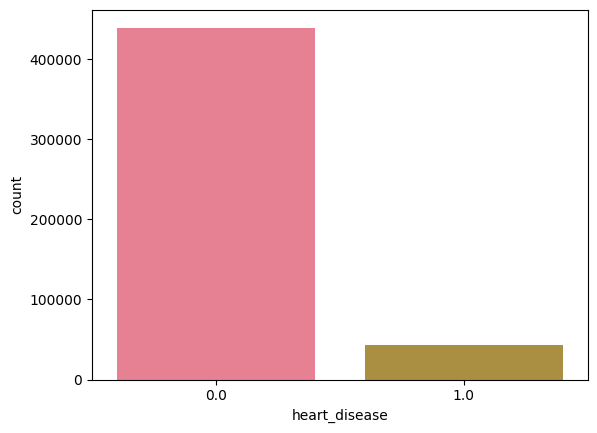

In [10]:
heart_df_train = pd.DataFrame(y_train, columns=['heart_disease'])
sns.countplot(x='heart_disease',data=heart_df_train)

In [11]:
ros = SMOTE(random_state=42)
X_train_res, y_train_res = ros.fit_resample(X_train,y_train)

In [12]:
heart_df_train_res = pd.DataFrame(y_train_res, columns=['heart_disease'])

<Axes: xlabel='heart_disease', ylabel='count'>

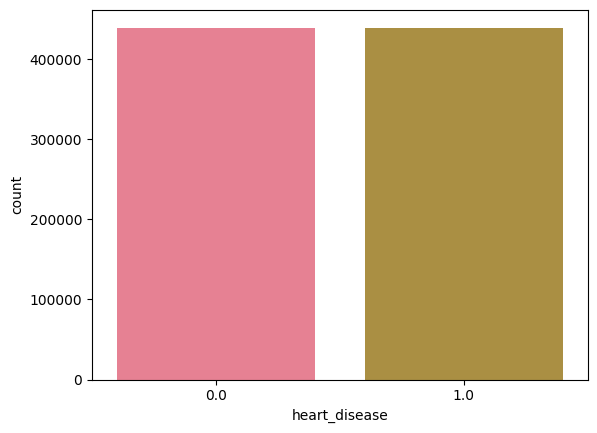

In [13]:
sns.countplot(x='heart_disease', data=heart_df_train_res)

### Changing Dimension of Data to run on GPU

## Train Models

In [15]:
base_model = DummyClassifier(strategy='most_frequent')
base_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [17]:
default_rf = xgb.XGBClassifier(tree_method='gpu_hist', use_label_encoder=False, eval_metric='logloss')
default_rf.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Random Search

# Save random search results to avoid re-running
if not os.path.exists('train/rcv_data.pkl'):
    model = RandomForestClassifier()
    param_grid = {'n_estimators': [100, 150, 200],
                'max_features': ['sqrt', 'log2'],
                'max_depth': [None, 2, 5, 10],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 5, 10],
                'bootstrap': [True, False]}
    rand_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='f1_weighted', n_iter=100, random_state=42, n_jobs=2, verbose=True)
    rand_search.fit(X_train_gpu, y_train_gpu)
    joblib.dump(rand_search, 'train/rcv_data.pkl')
else:
    rand_search = joblib.load('train/rcv_data.pkl')

print(f"Best params: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")
best_model = rand_search.best_estimator_

In [23]:
# Define the parameter grid for random search specific to XGBClassifier
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 2, 5, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 2, 5]
}

os.makedirs('train', exist_ok=True)

# Check if the results file exists
if not os.path.exists('train/rcv_data.pkl'):
    # Initialize XGBClassifier with GPU support
    model = xgb.XGBClassifier(tree_method='gpu_hist', use_label_encoder=False, eval_metric='logloss', verbosity=0)

    # Set up RandomizedSearchCV
    rand_search = RandomizedSearchCV(model, param_grid, cv=3, scoring='f1_weighted', n_iter=100, random_state=42, n_jobs=2, verbose=True)
    
    # Perform random search
    rand_search.fit(X_train, y_train)  # Note: Use CPU-based data arrays for fitting
    
    # Save the random search results
    joblib.dump(rand_search, 'train/rcv_data.pkl')
else:
    # Load the random search results
    rand_search = joblib.load('train/rcv_data.pkl')

# Print the best parameters and best score
print(f"Best params: {rand_search.best_params_}")
print(f"Best score: {rand_search.best_score_}")

# Get the best model
best_model = rand_search.best_estimator_

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best params: {'subsample': 1.0, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 1.0}
Best score: 0.9053460493642103


### MLPClassifier

In [24]:
if not os.path.exists('train/mlp_model.pkl'):
    mlp_model = MLPClassifier(hidden_layer_sizes=(100, 100, 100), max_iter=1000, verbose=True)
    mlp_model.fit(X_train, y_train)
    joblib.dump(mlp_model, 'train/mlp_model.pkl')
else:
    rand_search = joblib.load('train/mlp_model.pkl')

Iteration 1, loss = 0.24115504
Iteration 2, loss = 0.23551560
Iteration 3, loss = 0.23449585
Iteration 4, loss = 0.23380628
Iteration 5, loss = 0.23314991
Iteration 6, loss = 0.23236445
Iteration 7, loss = 0.23145570
Iteration 8, loss = 0.23052436
Iteration 9, loss = 0.22955958
Iteration 10, loss = 0.22855613
Iteration 11, loss = 0.22734911
Iteration 12, loss = 0.22610737
Iteration 13, loss = 0.22500723
Iteration 14, loss = 0.22380660
Iteration 15, loss = 0.22254098
Iteration 16, loss = 0.22135685
Iteration 17, loss = 0.22006141
Iteration 18, loss = 0.21898768
Iteration 19, loss = 0.21788711
Iteration 20, loss = 0.21677168
Iteration 21, loss = 0.21556922
Iteration 22, loss = 0.21422409
Iteration 23, loss = 0.21329902
Iteration 24, loss = 0.21226373
Iteration 25, loss = 0.21148670
Iteration 26, loss = 0.21045820
Iteration 27, loss = 0.20981828
Iteration 28, loss = 0.20857287
Iteration 29, loss = 0.20771602
Iteration 30, loss = 0.20707346
Iteration 31, loss = 0.20639343
Iteration 32, los

### Testing all models

In [25]:
def test_model(model, X_test, y_test, name='Model'):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)

    print(f"---- Results for {name} ----")
    print(report)
    print(f"SCORE (f1_weighted): {f1_score(y_test, y_pred, average='weighted')}\n\n")

test_model(base_model, X_test, y_test, name='Dummy (Baseline)')
test_model(default_rf, X_test, y_test, name='Random Forest')
test_model(mlp_model, X_test, y_test, name='MLP')
test_model(best_model, X_test, y_test, name='Random Forest (Optimized)')

---- Results for Dummy (Baseline) ----
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95    109735
         1.0       0.00      0.00      0.00     10952

    accuracy                           0.91    120687
   macro avg       0.45      0.50      0.48    120687
weighted avg       0.83      0.91      0.87    120687

SCORE (f1_weighted): 0.8660359051614009


---- Results for Random Forest ----
              precision    recall  f1-score   support

         0.0       0.95      0.89      0.92    109735
         1.0       0.31      0.49      0.38     10952

    accuracy                           0.85    120687
   macro avg       0.63      0.69      0.65    120687
weighted avg       0.89      0.85      0.87    120687

SCORE (f1_weighted): 0.8686509237493185


---- Results for MLP ----
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.96    109735
         1.0       0.62      0.29      0.40     1095

### Training Best model

In [29]:
best_model = xgb.XGBClassifier(tree_method='gpu_hist',n_estimators=200, min_samples_split=5, min_samples_leaf=2, max_features='sqrt', max_depth=10, bootstrap=False)
best_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, bootstrap=False, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_features='sqrt',
              max_leaves=None, min_child_weight=None, min_samples_leaf=2,
              min_samples_split=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, ...)

### Uploading model to feature store

In [32]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="heart_model"
os.makedirs(model_dir, exist_ok=True)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(best_model, model_dir + "/heart_model.pkl")
# Already stored in the feature extraction
joblib.dump(preprocessing_pipeline, model_dir + "/preprocessing_pipeline.pkl")


# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
heart_model = mr.python.create_model(
    version=1.1,
    name="heart_model_v1", 
    model_schema=model_schema,
    description="Heart Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
heart_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/9975 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/4889186 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/243 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/809108/models/heart_model_v1/1


Model(name: 'heart_model_v1', version: 1)